## Imports

Make sure you append the correct path to where the folder containing the packages are located.

In [15]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/github/') 
import os
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from packages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration
import hyperspy.api as hs

## Loading the data

There is a variety of ways of loading the data into the scripts, here we opt to import the images as .tif using the ImageProcessing class. The only requirement is that the data is loaded as numpy arrays of 16 bit datatype. 

In [48]:
#Read the folder and import the desired number of images, only .tif images will be loaded
directory = os.getcwd() + '/data/'
processing = ImageProcessing(directory)
imgs, _ = processing.load_images(1)

#The images are output as a list, you can assign one image, make a mean, or sum
img = imgs[0] 

You can import images from .ser files, generated by ThermoFischer software, using Hyperspy.

In [44]:
#Load .ser data
directory = '...'
names = [x for x in os.listdir(directory) if x.endswith('.ser')] 

file_path = os.path.join(directory, names[0])
data = hs.load(file_path, signal_type='diffraction', lazy=True)
imgs, = np.array(data)
img = imgs[0] 

FileNotFoundError: [Errno 2] No such file or directory: '...'

Here’s a more organized version of the markdown cell:

## Finding the Center of the Diffraction Pattern

The `find_center` function uses the Hough circle transform and edge detection methods to locate the center of the diffraction pattern. The remainder of the cell plots the identified circle.

### Algorithm Steps

1. **Normalize the Image**
   - Normalize the image to 8 bits, with pixel values ranging from 0 to 255.
   - Clip values below a certain threshold to retain only the most intense halo and the direct beam.

2. **Apply Edge Detection**
   - Use the OpenCV edge detection algorithm ([Canny Edge Detector](https://docs.opencv.org/4.x/da/d5c/tutorial_canny_detector.html)).
   - This intermediate step simplifies the subsequent Hough Circle Transform.

3. **Hough Circle Transform**
   - The implemented algorithm, known as the Hough Gradient, is based on the Hough transform and involves two stages:
     1. **Edge Detection**: Detect edges in the image to define the search points, facilitated by the intermediate edge outlining step.
     2. **Accumulator Matrix**: Scan the image with an accumulator matrix, recording the positions of these points. The highest value in this matrix indicates the circle's center, and the radius is also derived from this matrix.

### References

- [OpenCV Edge Detection Algorithm](https://docs.opencv.org/4.x/da/d5c/tutorial_canny_detector.html)
- [Hough Circle Transform](https://docs.opencv.org/4.10.0/d4/d70/tutorial_hough_circle.html)

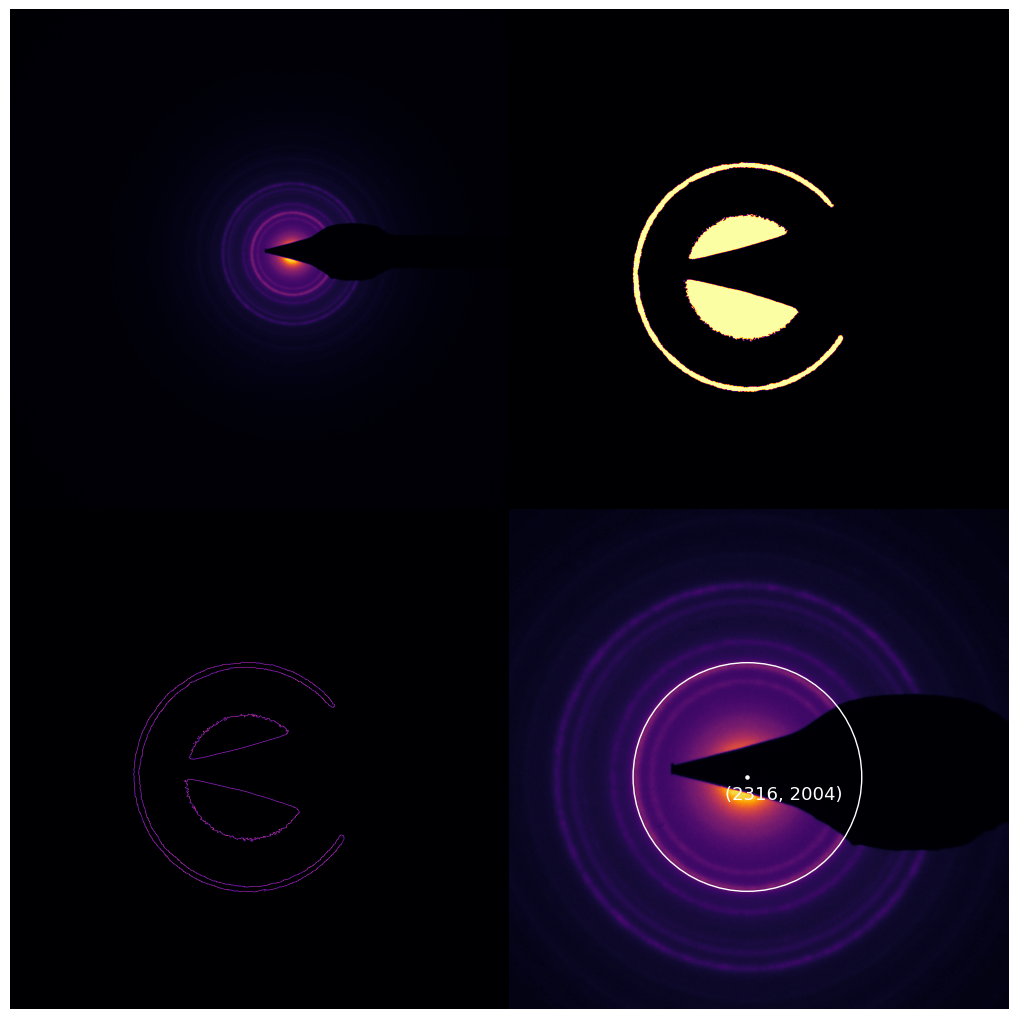

In [49]:
from matplotlib.patches import Circle

analysis = ImageAnalysis()
#The outputs are all 
center_x, center_y, r, thresh, canny  = analysis.find_center(img, r = 1, #smallest radius
                                                            R = 5000, #biggest radius
                                                            threshold = 70, #threshold applied to the difratogram
                                                            edges_thresh1 = 255, #canny edge detector threshold
                                                            edges_thresh2 = 10)  #canny edge detector threshold

circle1 = Circle((center_x, center_y), r,  fill = False, color='white')

f, ax = plt.subplots(2,2, figsize = (10,10))
ax[1,1].imshow(img, cmap = 'inferno')
ax[1,1].scatter(center_x, center_y, s=5, color ='white')
ax[1,1].add_patch(circle1)
ax[1,1].axis('off')
ax[1,1].text(center_x+110, center_y+50, f'{center_x, center_y}', color='white', fontsize=13, ha='center', va='center')
zoom_start = 1600
zoom_end = 3100
ax[1,1].set_xlim(zoom_start, zoom_end)
ax[1,1].set_ylim(2700, 1200)  # Note: y-limits are reversed in images

ax[0,0].imshow(img, cmap = 'inferno')
ax[0,0].axis('off')

ax[1,0].imshow(canny, cmap='inferno')
ax[1,0].axis('off')
ax[1,0].set_xlim(zoom_start, zoom_end)
ax[1,0].set_ylim(2700, 1200) 

ax[0,1].imshow(thresh, cmap='inferno')
ax[0,1].axis('off')
ax[0,1].set_xlim(zoom_start, zoom_end)
ax[0,1].set_ylim(2700, 1200) 
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(pad=0)
plt.show()

## Optional: Testing the precision of the identified center

We can verify the symmetry of the identified center by averaging azimuthally in both the x and y directions. If the position of the peaks are aligned, the center is correct.

  File "/tmp/ipykernel_273515/4075350206.py", line 4, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)


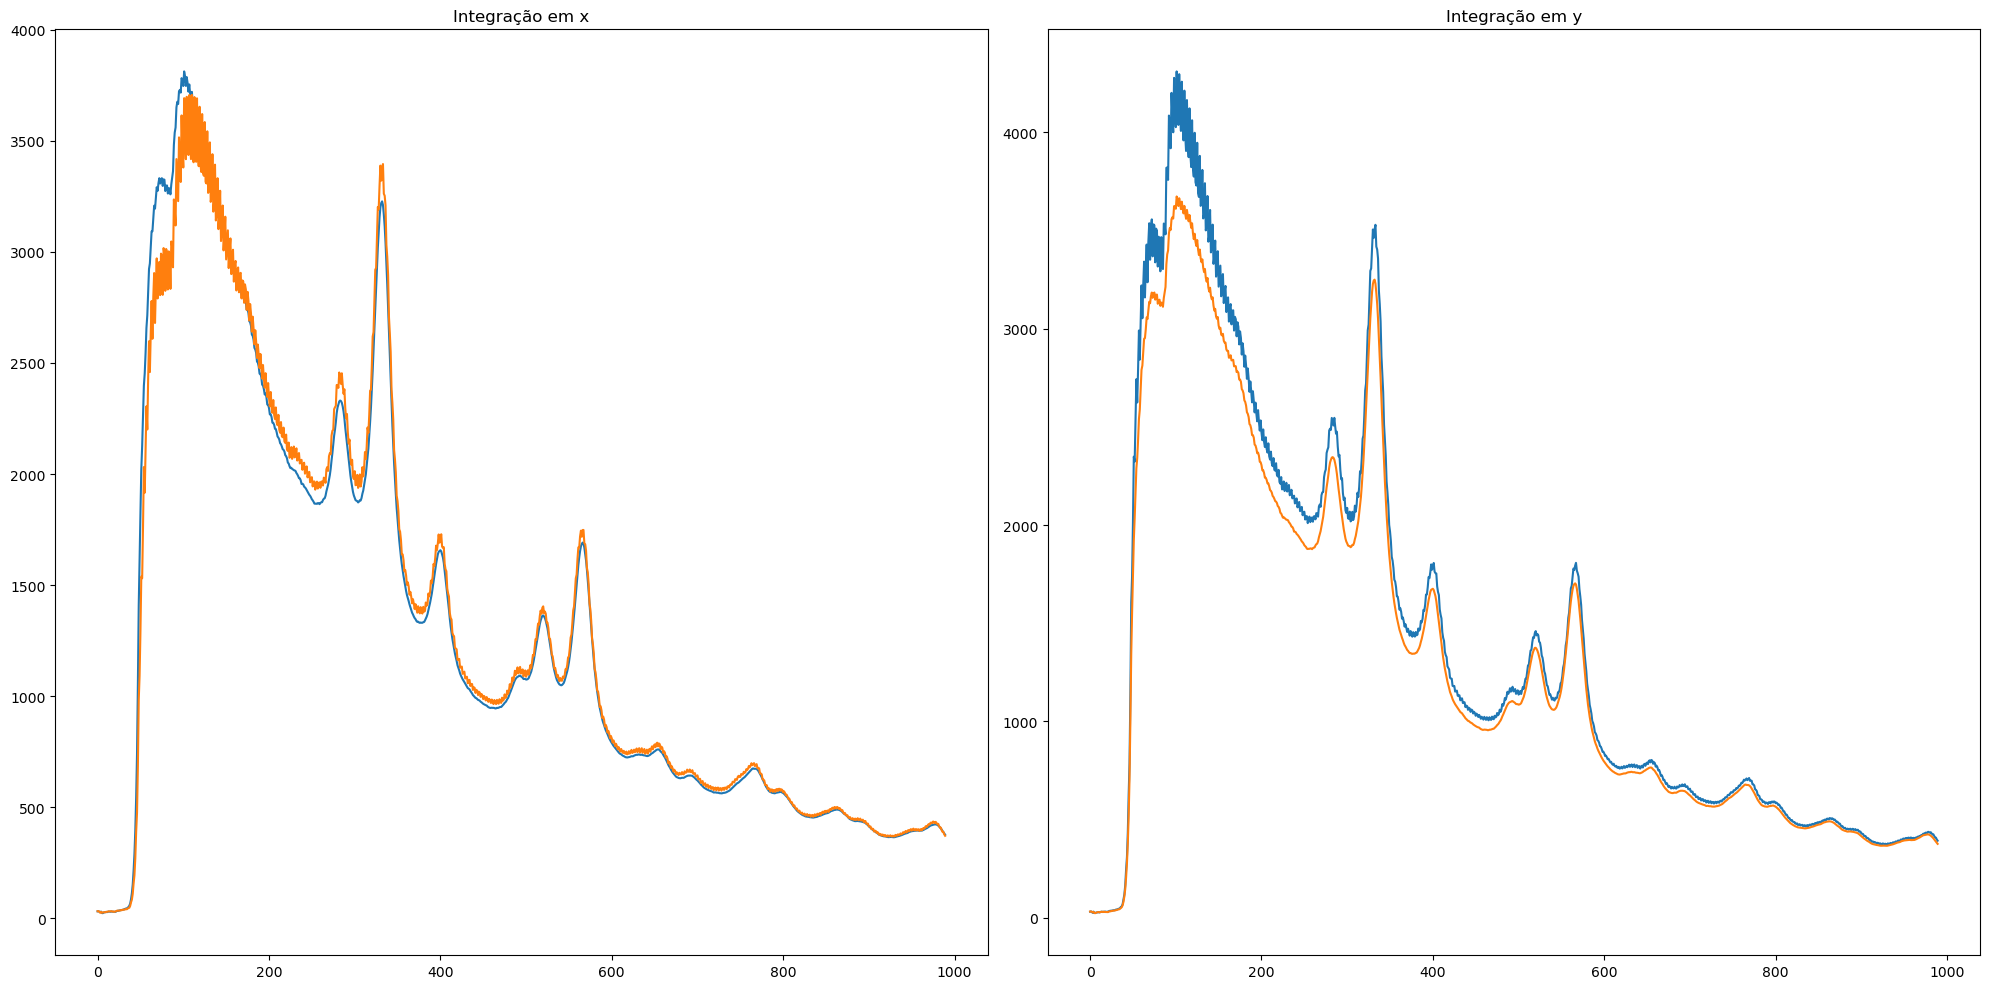

In [50]:
#Tune the binning of the averaging to the furthest distance to the border of the diffraction
binning = 3000

ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)

res1 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(325, 305), method = "ocl_lut_integr")
res2 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(125, 145), method = "ocl_lut_integr")
res3 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(80, 100), method = "ocl_lut_integr")
res4 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(-80, -100), method = "ocl_lut_integr")

plot_range = int(0.33*binning)

fig, ax = plt.subplots(1,2,figsize=(20, 10))

ax[0].set_title('Integração em x')
ax[0].plot(res1[1][0:plot_range])
ax[0].plot(res2[1][0:plot_range])

ax[1].set_title('Integração em y')
ax[1].plot(res3[1][0:plot_range])
ax[1].plot(res4[1][0:plot_range])

plt.tight_layout()
plt.show()

## Azimuthal average and saving

Plotting and saving the intensity of the azimuthally averaged diffraction. The x-axis is not saved as it is not 

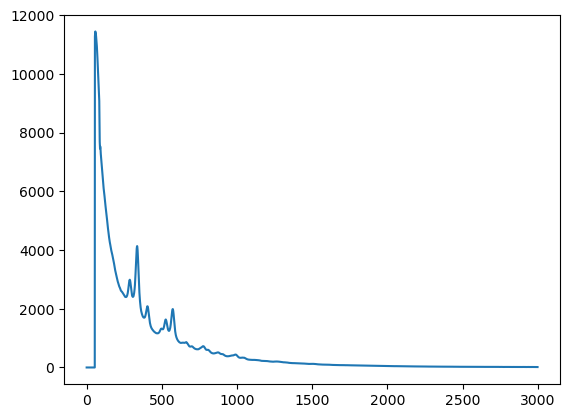

In [54]:
#First we mask the beamstopper on the image
mask = processing.load_mask( os.getcwd() + '/data/MASKS/mask_titan.tif')
img[mask == 255] = -100

#The averaging does not account for the masked pixels
data, polar_image, _ = analysis.azimuth_integration_cv2(img, center = [center_x, center_y], binning=binning)
plt.plot(data)

#The data will save in the folder IQ
processing.save_iq_only_y(data, 'Fe3O4')